# Visualizing and clustering gene expression trends

In this tutorial, you will learn how to...

- compute and visualize gene expression trends along specific differentiation trajectories. 
- cluster expression trends to detect genes with similar dynamical patterns. 

To demonstrate the appproach in this tutorial, we use a scRNA-seq dataset of pancreas development at embyonic day E15.5 <cite data-cite="bastidas-ponce:19"></cite>. We used this dataset in our [cellrank meets rna velocity](https://cellrank.readthedocs.io/en/stable/cellrank_meets_rna_velocity.html), [initial & terminal states](https://cellrank.readthedocs.io/en/stable/initial_terminal_states.html) and [fate probabilities & driver genes](https://cellrank.readthedocs.io/en/stable/fate_probabilities.html) tutorials to compute a cell-cell transition matrix, infer terminal states and uncover fate probabilities, respectively; this tutorial builds on analysis presented there. 

<div class="alert alert-info">
Important

If you want to run this on your own data, you will need...

- a scRNA-seq dataset for which you computed a cell-cell transition matrix using any CellRank kernel. For each kernel, there exist individual tutorials that teach you how to use them. 
- any pseudotime computed on your data. We'll use the Palantir pseudotime in our example (CITE).
- imputed gene expression data. We'll use MAGIC here, but you can use any imputation strategy that works for your data (CITE). 

</div>

This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/raw/master/tutorials/fate_probabilities.ipynb).

## Import packages & data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank@dev

In [3]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import pandas as pd

from scipy.stats import ttest_ind
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

Global seed set to 0


In [4]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

Read AnnData object from disk (or download). 

In [5]:
adata = sc.read('datasets/ML_2022-06-23_pancreas_with_transition_matrix.h5ad')

Additional MAGIC imputed expression for this data example is available on [Figshare](https://ndownloader.figshare.com/files/25120526?private_link=7e192d9821165855eaff0). See the [MAGIC documentation](https://krishnaswamylab.org/projects/magic) or CellRank's [reproducibility repo](https://github.com/theislab/cellrank_reproducibility/blob/master/notebooks/fig_5_benchmarking/palantir/ML_2021-10-26_palantir.ipynb) for more info.  

In [6]:
magic_imputed_data = pd.read_csv("datasets/pancreas_magic_imputed_data.csv", index_col=0)

# filter to those genes for which we have imputed expression values (all but 4)
mask = np.in1d(adata.var_names, magic_imputed_data.columns)
adata = adata[:, mask].copy()

# add imputed data to an extra layer in AnnData
adata.layers['magic_imputed_data'] = magic_imputed_data[adata.var_names].loc[adata.obs_names]

Reconstruct a [VelocityKernel](https://cellrank.readthedocs.io/en/latest/api/_autosummary/kernels/cellrank.kernels.VelocityKernel.html#) from the AnnData object. 

In [7]:
vk = cr.kernels.VelocityKernel.from_adata(adata, key='T_fwd')
vk

VelocityKernel[n=2531, model='deterministic', similarity='correlation', softmax_scale=3.797]

<div class="alert alert-info">
Important

The method `from_adata()` allows you to reconstruct a CellRank kernel from an [AnnData](https://anndata.readthedocs.io/en/latest/) object. When you use a kernel to compute a transition matrix, this matrix, as well as a few informations about the computation, are written to the underlying AnnData object. This makes it easy to write and read kernels from disk via the associated AnnData object. 

</div>

In [8]:
adata

AnnData object with n_obs × n_vars = 2531 × 1996
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'T_fwd_params', 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_params'
    obsm: 'T_fwd_umap', 'X_pca', 'X_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'spliced', 'unspliced', 'velocity', 'velocity_u

## Compute terminal states and fate probabilities

We need to infer or assign terminal states and compute fate probabilities before we can visualize gene expression trends. We will go over this quickly here, to learn more, see the [initial and terminal states](https://cellrank.readthedocs.io/en/stable/initial_terminal_states.html) and [fate probabilities & driver genes](https://cellrank.readthedocs.io/en/stable/fate_probabilities.html) tutorials. 

In [9]:
g = cr.estimators.GPCCA(vk)
print(g)

GPCCA[kernel=VelocityKernel[n=2531], initial_states=None, terminal_states=None]


Fit the estimator to obtain macrostates, declare terminal states, and compute fate probabilities

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[11]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Computing `12` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:07)
Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Computing absorption probabilities


  0%|          | 0/4 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.absorption_probabilities`
    Finish (0:00:00)


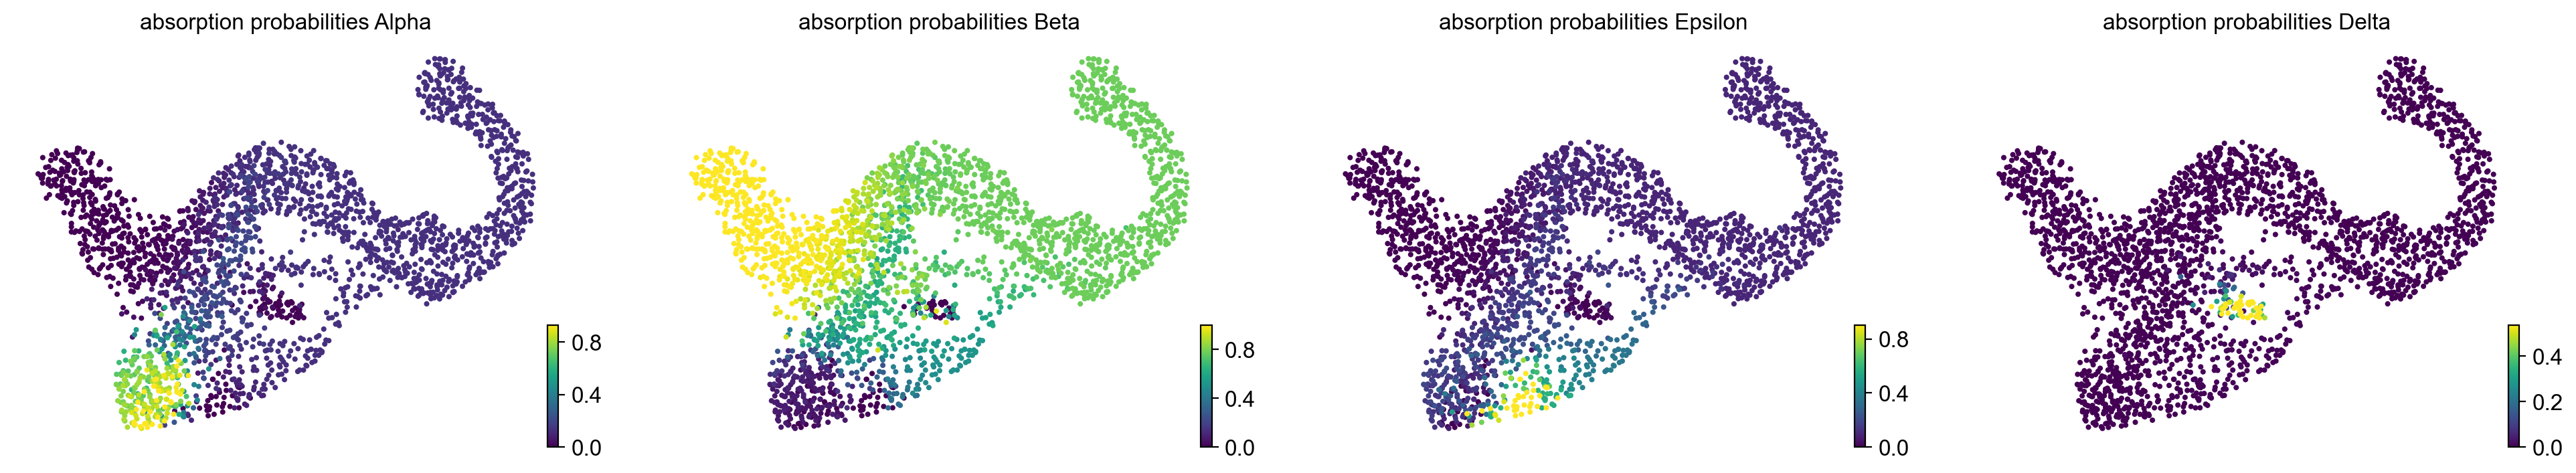

In [10]:
# compute macrostates
g.fit(cluster_key='clusters', n_states=12)

# declare terminal states
g.set_terminal_states(states=['Alpha', 'Beta', 'Epsilon', 'Delta'])

# compute and visualize fate probabilities
g.compute_absorption_probabilities()
g.plot_absorption_probabilities(same_plot=False)

## Visualize one gene across several trajectories

To visualize gene expression trends, we fit [Generalized Additive Models (GAMs)](https://en.wikipedia.org/wiki/Generalized_additive_model) to MAGIC-imputed gene expression data, ordering cells in pseudotime, and weighting each cell's contribution to each trajectory according to fate probabilities. Let's start by visulizing the Palantir pseudotime that we will be using. 

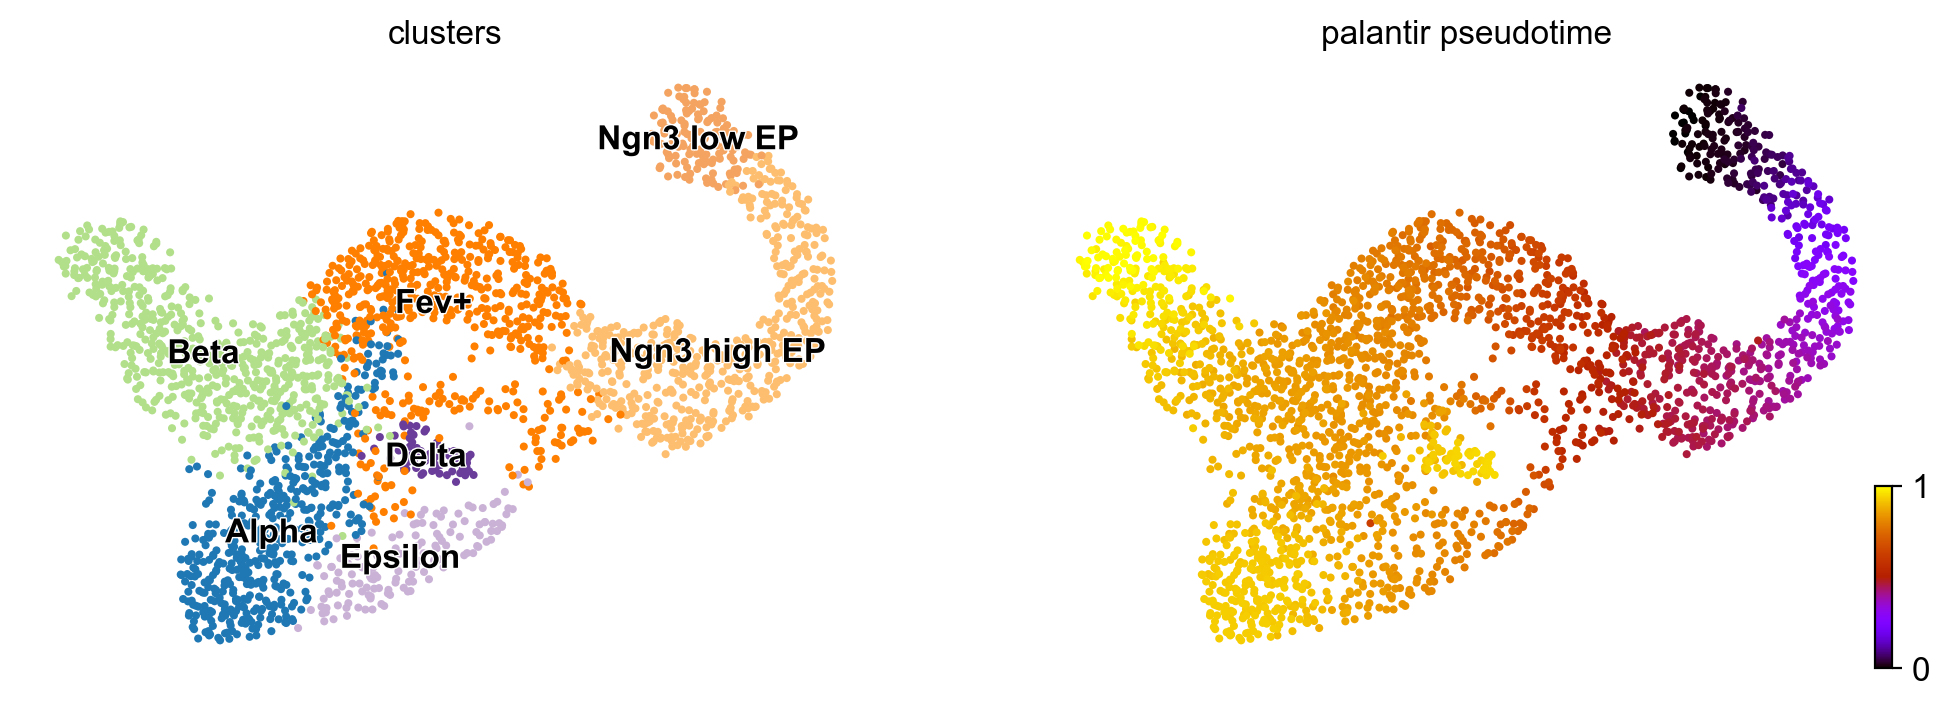

In [13]:
scv.pl.scatter(adata, c=["clusters", "palantir_pseudotime"], color_map="gnuplot", legend_loc="on data")

This looks promising, the pseudotime increases continiously from early states (Ngn3 low EP) until late states (Alpha, Beta, Delta, Epsilon). We can make this more quantitative, without relying on the 2D UMAP, by showing the distribution of pseudotime values per cluster. 

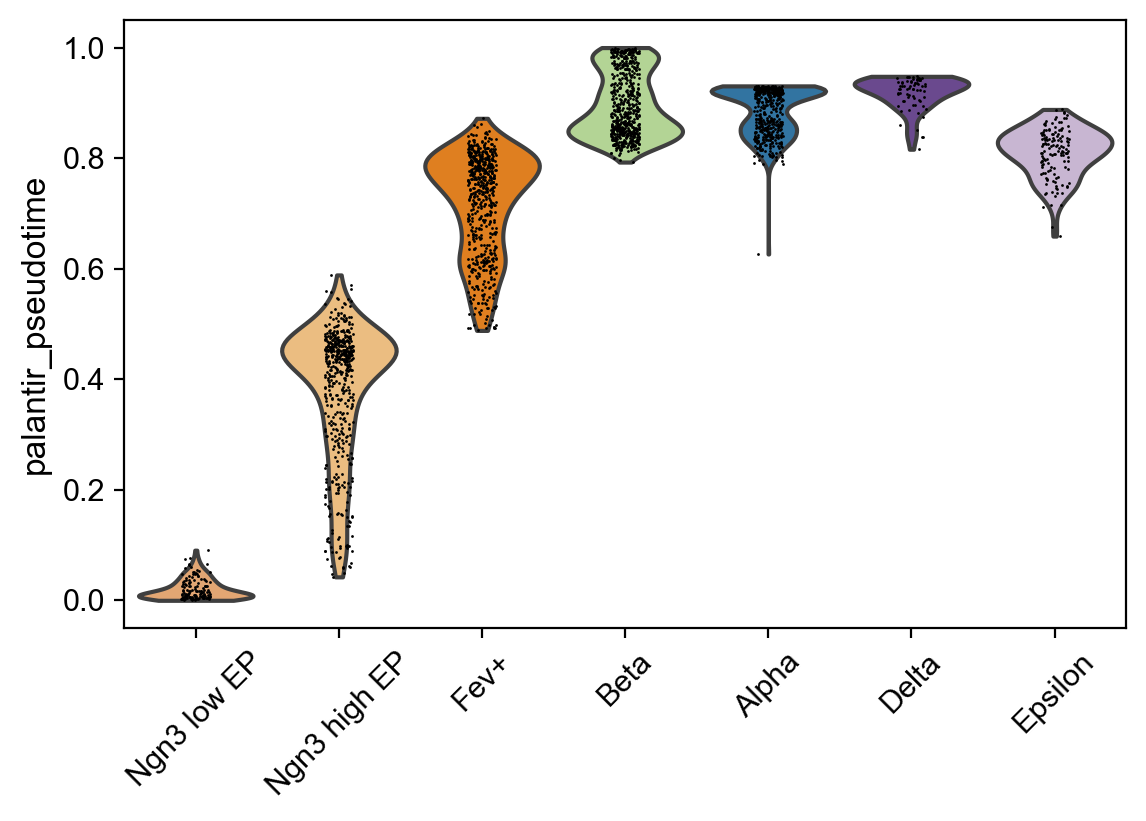

In [16]:
sc.pl.violin(adata, keys=["palantir_pseudotime"], groupby="clusters", rotation=45)

This confirms what we saw in the UMAP. 

In [23]:
pseudotime = 'palantir_pseudotime'
data_key = 'magic_imputed_data'

fig_2_genes = ['Arx', 'Pdx1', 'Hhex']

# pyGAM settings
n_knots = 10
weight_threshold = (0.05, 0.05)

# mgcv settings
n_knots_mgcv = 6
weight_threshold_mgcv = (1e-3, 1e-3)
smoothing_penalty_mgcv = 10.0

Computing trends using `1` core(s)


  0%|          | 0/3 [00:00<?, ?gene/s]

    Finish (0:00:00)
Plotting trends


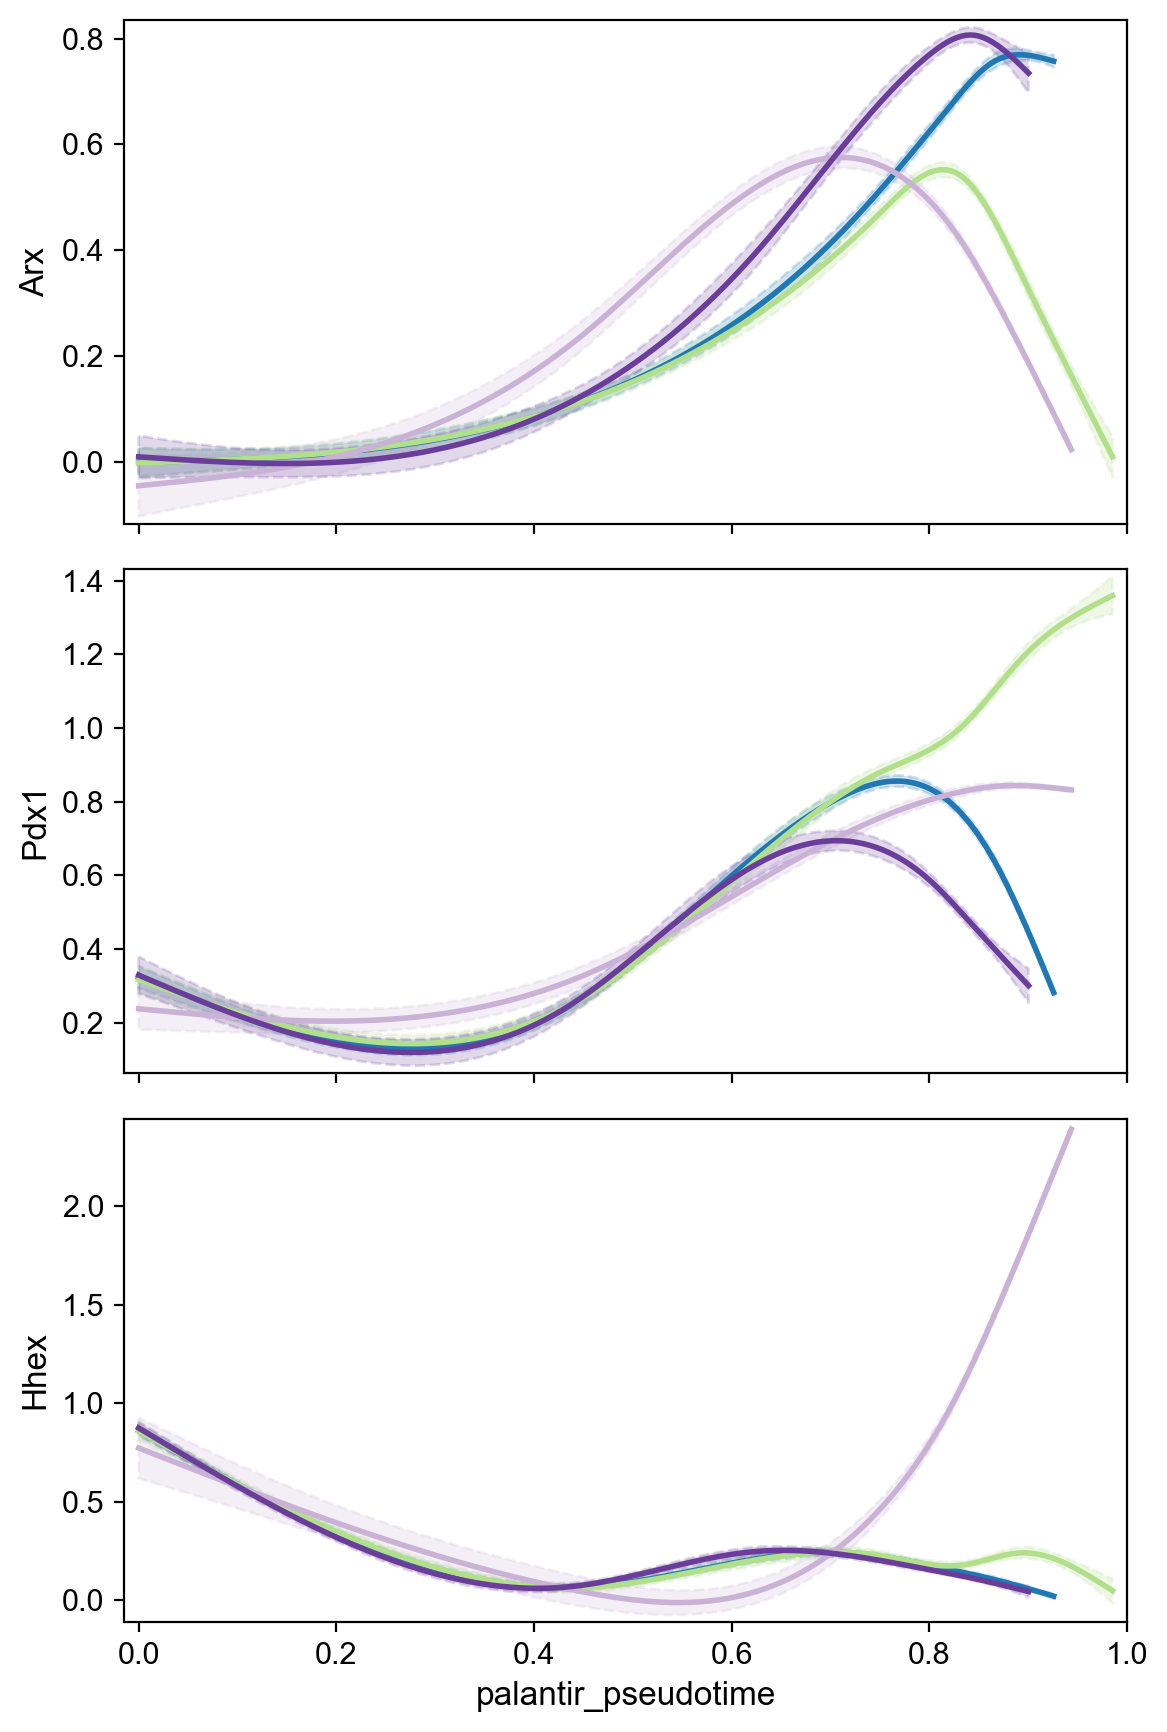

In [24]:
# using mgcv
model = cr.models.GAMR(adata, n_knots=n_knots_mgcv, smoothing_penalty=smoothing_penalty_mgcv)
    

fig_kwargs = {'model': model,
              'data_key': data_key, 
              'gene_as_title': False, 
              'legend_loc': None,
              'genes': fig_2_genes, 
              'ncols': 1,
              'time_key': pseudotime, 
              'same_plot': True, 
              'hide_cells': True,
              'weight_threshold': weight_threshold_mgcv, 
              'figsize': (6, 9), 
              'suptitle': ''}

cr.pl.gene_trends(adata, **fig_kwargs)

## Visualize several genes across one trajectory

## Cluster gene expression trends across one trajectory

## What's next? 

In this tutorial, you learned how to compute, aggregate and visualize fate probabilities and predict driver genes. For the next steps, we recommend...

- going through the [gene trend plotting tutorial](https://cellrank.readthedocs.io/en/stable/notebooks/tutorials/gene_trends.html) to learn how to visulize gene dynamics in pseudotime.
- taking a look at the [full API](https://cellrank.readthedocs.io/en/stable/api.html) to learn about parameter values you can use to adapt these computations to your data. 
- trying this out on your own data. 

If you encounter any bugs in the code, our if you have suggestions for new features, please open an [issue](https://github.com/theislab/cellrank/issues/new/choose). If you have a general question or something you would like to discuss with us, please post on the [scverse discourse](https://discourse.scverse.org/c/ecosytem/cellrank/40). 

## Package versions

In [16]:
cr.logging.print_versions()

cellrank==1.5.1+gedbc651e scanpy==1.9.3 anndata==0.8.0 numpy==1.24.2 numba==0.57.0rc1 scipy==1.10.1 pandas==1.5.3 pygpcca==1.0.4 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 scvelo==0.3.0 pygam==0.8.0 matplotlib==3.7.0 seaborn==0.12.2
